# MCMC: planning a telescope observation. 

You want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

$$p({\rm clear \; tomorrow} \, |\,  {\rm cloudy \; today}) = 0.5,$$

which means that

$$p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5.$$

We also have

$$p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1,$$

which means that

$$p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9.$$


- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree. 
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at

$$p({\rm clear}) = 0.83,$$

and 

$$p({\rm cloudy}) = 0.17.$$

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are, indeed, a **MARKOV CHAIN**.


#### Tasks

- Start off on a cloud day. 
- Implement your weather forecast based on the above probabilities
- Run your simulator for N days (with $N\gtrsim 10^4$)
- Prepare a plot with the number of days on the x axis and the cumulative number of, say, sunny days over the number of days so far on the y axis. This is called a **trace-plot**, showing how our estimate of $p(\mathrm{clear})$ evolves as the chain samples.  
- Prepare a histogram of the above plot. This reveals the distribution of $p(\mathrm{clear})$.
- Use a summary statistics to determine the most likely value and an error on our estimate.

**Important:** 
- In MCMC the process must be **stationary** which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.  
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a **burn-in** phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but ***you should always start with a traceplot of your samples!***

#### Tasks

- In the above example, experiment with chopping off different numbers of initial points as burn-in.

In [1]:
import scipy as sp
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# set the known probabilities

p_clear = 0.83
p_cloudy = 0.17

p_clear_tom_cloudy_tod = 0.5
p_cloudy_tom_cloudy_tod = 0.5

p_cloudy_tom_clear_tod = 0.1
p_clear_tom_clear_tod = 0.9

N_samples = 100000  # days

### Define the functions: 
I set $0$ for clear days and $1$ for cloudy days: 

In [3]:
def WeatherProbabilities(current_weather, proposed_weather): 
    
    if current_weather == 1: 
        
        return 0.5  # p_clear_tom_cloudy_tod
    
    if current_weather == 0: 
        
        if proposed_weather == 1: 
            
            return 0.1  # p_cloudy_tom_clear_tod
        
        if proposed_weather == 0: 
            
            return 0.9  # p_clear_tom_clear_tod

In [4]:
def WeatherForecast(samples=N_samples, init_weather=1, plot=False):
    
    current_weather = init_weather
    post = [init_weather]
    
    for i in range(samples):
        
        proposed_weather = np.random.randint(0, 2)
        
        # evaluating probability of 
        p_accept = WeatherProbabilities(current_weather, proposed_weather)
        
    
        # Accept if p_accept > 1 (since random limited to [0,1]) and if p_accept > rand as well
        accept = uniform.rvs() < p_accept
        
        
        if accept:
            # Update position
            current_weather = proposed_weather
        
        post.append(current_weather)
        
    return np.array(post)

In [5]:
posterior = WeatherForecast()

In [6]:
prob_clear = np.count_nonzero(posterior == 0) / len(posterior)

In [7]:
prob_cloudy = np.count_nonzero(posterior == 1) / len(posterior)

In [8]:
print("Cloudy: ", prob_cloudy * 100, "%")
print("Clear: ", prob_clear * 100, "%")

Cloudy:  16.455835441645583 %
Clear:  83.54416455835441 %


Let's see the MCMC trace: 

In [9]:
n_days = np.arange(1, N_samples)
trace_p_clear = np.array([ float(np.count_nonzero(posterior[:i] == 0) / n_days[i]) for i in range(0, len(n_days))])
trace_p_cloudy = np.array([ float(np.count_nonzero(posterior[:i] == 1) / n_days[i]) for i in range(0, len(n_days))])

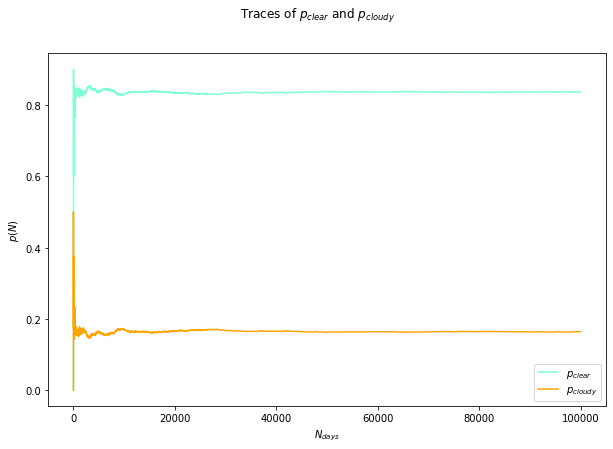

In [10]:
plt.figure(figsize = (10, 6.5))
plt.plot(n_days, trace_p_clear, color = 'aquamarine', label="$p_{clear}$");
plt.plot(n_days, trace_p_cloudy, color = 'orange', label="$p_{cloudy}$");
plt.ylabel('$p(N)$')
plt.xlabel('$N_{days}$')
plt.suptitle("Traces of $p_{clear}$ and $p_{cloudy}$")
plt.legend();

Zooming in (excluding the first 100 days for instance): 

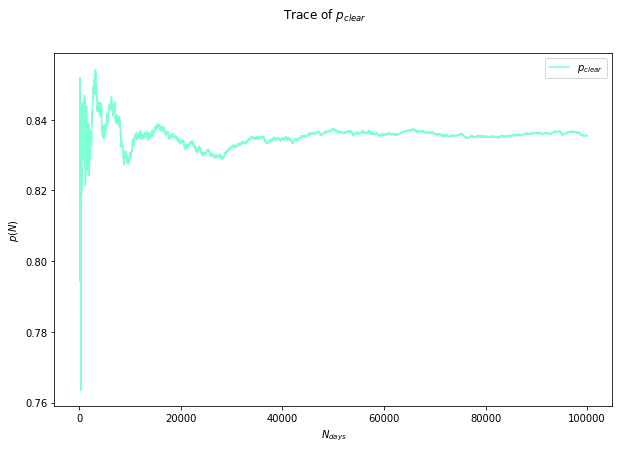

In [11]:
plt.figure(figsize = (10, 6.5))
plt.plot(n_days[100:], trace_p_clear[100:], color = 'aquamarine', label="$p_{clear}$");
plt.ylabel('$p(N)$')
plt.xlabel('$N_{days}$')
plt.suptitle("Trace of $p_{clear}$")
plt.legend();

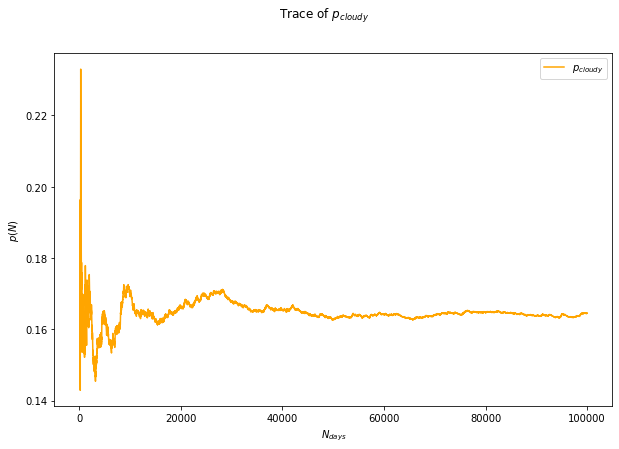

In [12]:
plt.figure(figsize = (10, 6.5))
plt.plot(n_days[100:], trace_p_cloudy[100:], color = 'orange', label="$p_{cloudy}$");
plt.ylabel('$p(N)$')
plt.xlabel('$N_{days}$')
plt.suptitle("Trace of $p_{cloudy}$")
plt.legend();

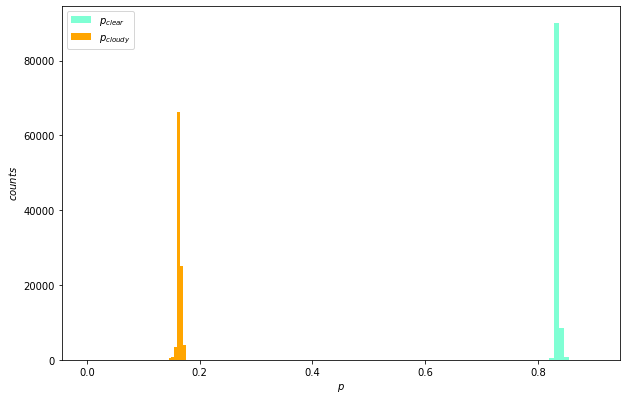

In [13]:
# produce the histogram. 
plt.figure(figsize = (10, 6.5))

plt.hist(trace_p_clear, bins=100, color='aquamarine', label="$p_{clear}$")
plt.hist(trace_p_cloudy, bins=100, color='orange', label="$p_{cloudy}$")

plt.xlabel("$p$")
plt.ylabel("$counts$")
plt.legend();

I'll try to discard some initial trace-data points to see if that changes: 

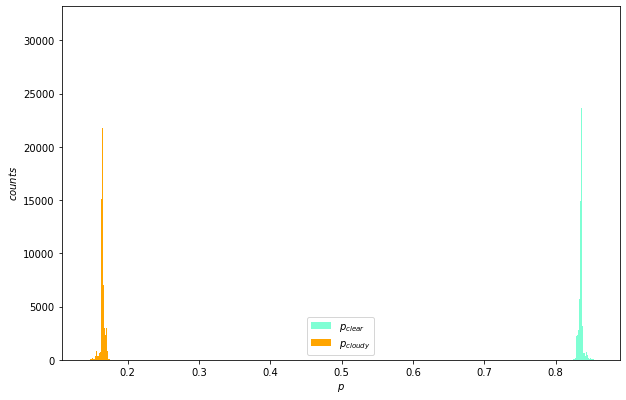

In [14]:
# produce the histogram. 
plt.figure(figsize = (10, 6.5))

plt.hist(trace_p_clear[100:], bins=100, color='aquamarine', label="$p_{clear}$")
plt.hist(trace_p_cloudy[100:], bins=100, color='orange', label="$p_{cloudy}$")

plt.xlabel("$p$")
plt.ylabel("$counts$")
plt.legend();

It doesn't really change in shape, but at least I am sure I did not take into accout the first $N = 100$ numbers (burn-in). I now will use some statistics to evaluate the error and the mean of the values for each $p$: 

In [15]:
mean_p_clear = np.mean(trace_p_clear[100:])
mean_p_cloudy = np.mean(trace_p_cloudy[100:])

In [16]:
print("Mean p_clear: ", mean_p_clear)
print("Mean p_cloudy: ", mean_p_cloudy)

Mean p_clear:  0.8353336014076176
Mean p_cloudy:  0.16459730121791175


For the error it's a little tricky, because I am not sure the $\sigma_{std}$ is a correct value of dispersion around the maxima. All I can do is introduce the intervals of credibility for the $p$ values I am studying: I am going to use the percentiles.

In [17]:
print("68% credibility interval p_clear: (", np.percentile(trace_p_clear[100:], 16), ",", np.percentile(trace_p_clear[100:], 84), ").")
print("68% credibility interval p_cloudy: (", np.percentile(trace_p_cloudy[100:], 16), ",", np.percentile(trace_p_cloudy[100:], 84), ").")

68% credibility interval p_clear: ( 0.8335406395022936 , 0.8366135977824889 ).
68% credibility interval p_cloudy: ( 0.16336352325041728 , 0.16640598800996628 ).
